In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from fredapi import Fred
import sqlite3
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import matplotlib.dates as mdates
from pandas.tseries.offsets import Day
from decimal import Decimal
import requests
import seaborn as sns
color_pal = sns.color_palette()

In [9]:
ticker = "^GSPC"
start_date = "1950-01-01"
end_date = "2024-11-06"

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


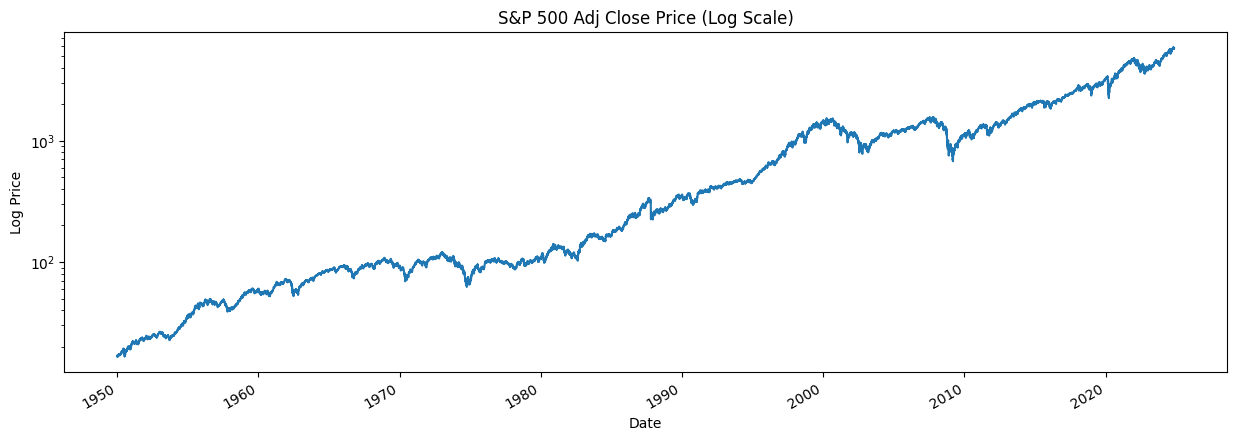

In [10]:
data['Adj Close'].plot(style='-', figsize=(15, 5), color=color_pal[0], title='S&P 500 Adj Close Price (Log Scale)') 
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.show()

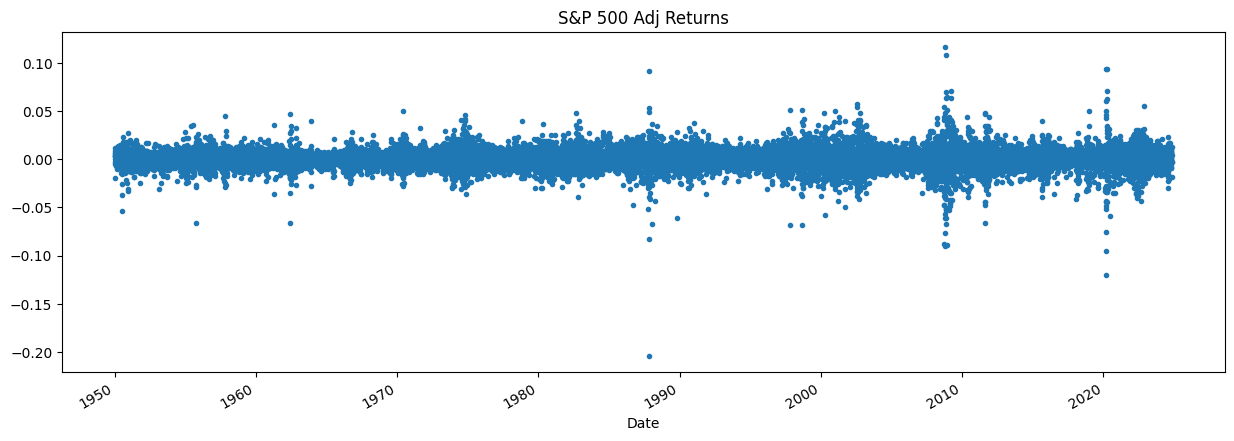

In [11]:
# Calculate daily returns and set the first day's return to 0
data['Index_Returns'] = data['Adj Close'].pct_change().fillna(0).dropna()
data['Index_Returns'].plot(style='.', figsize=(15, 5), color=color_pal[0], title='S&P 500 Adj Returns') 
plt.xlabel('Date')
plt.show()

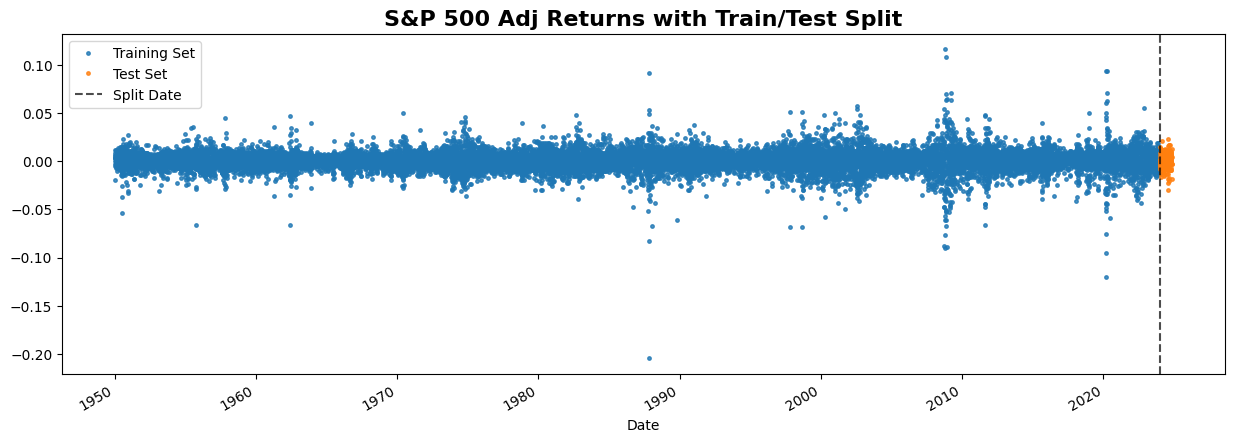

In [12]:
# Assuming color_pal is defined, e.g., color_pal = ['#1f77b4', '#ff7f0e']
split_date = '2024-01-01'

# Separate train and test sets for 'Index_Returns'
train = data.loc[data.index < split_date, 'Index_Returns']
test = data.loc[data.index >= split_date, 'Index_Returns']

# Plot with dot style
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, style='.', label='Training Set', color=color_pal[0], alpha=0.8, markersize=5)
test.plot(ax=ax, style='.', label='Test Set', color=color_pal[1], alpha=0.8, markersize=5)
ax.axvline(pd.to_datetime(split_date), color='black', linestyle='--', lw=1.5, alpha=0.7)
ax.set_title('S&P 500 Adj Returns with Train/Test Split', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.legend(['Training Set', 'Test Set', 'Split Date'], loc='upper left', frameon=True)
plt.show()

In [14]:
train

Date
1950-01-03    0.000000
1950-01-04    0.011405
1950-01-05    0.004748
1950-01-06    0.002953
1950-01-09    0.005889
                ...   
2023-12-22    0.001660
2023-12-26    0.004232
2023-12-27    0.001430
2023-12-28    0.000370
2023-12-29   -0.002826
Name: Index_Returns, Length: 18619, dtype: float64

In [15]:
# Train Markov Switching Model on the Training Data
train_model = MarkovRegression(train, k_regimes=2, trend='c', switching_variance=True)
train_result = train_model.fit()
data['Predicted_Vol__Training_Regime'] = result.smoothed_marginal_probabilities.idxmax(axis=1)

C:\Users\NicholasRatti\anaconda3\envs\msm_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


NameError: name 'result' is not defined

In [ ]:
# Print all parameter names and values
print(train_result.params)

In [ ]:
# Get the smoothed probabilities DataFrame
smoothed_probs = train_result.smoothed_marginal_probabilities

# Get the last known probabilities (at time t)
last_probs = smoothed_probs.iloc[-1]

In [ ]:
# Extract transition probabilities from the model parameters
params = train_result.params

# Transition probabilities
p_00 = params['p[0->0]']  # Probability of staying in Regime 0
p_10 = params['p[1->0]']  # Probability of moving from Regime 1 to Regime 0

# Probabilities of transitioning to Regime 1
p_01 = 1 - p_00          # Probability of moving from Regime 0 to Regime 1
p_11 = 1 - p_10          # Probability of staying in Regime 1

In [ ]:
# Construct the transition matrix
transition_matrix = np.array([
    [p_00, p_01],  # Transitions from Regime 0
    [p_10, p_11]   # Transitions from Regime 1
])

print("Transition Matrix:")
print(transition_matrix)

In [ ]:
# Get the smoothed probabilities DataFrame
smoothed_probs = train_result.smoothed_marginal_probabilities

# Get the last known probabilities (at time t)
last_probs = smoothed_probs.iloc[-1].values  # Convert to NumPy array

# Regime labels
regime_labels = smoothed_probs.columns.tolist()  # Should be [0, 1]

print("Last Known State Probabilities:")
print(f"Regime {regime_labels[0]}: {last_probs[0]}")
print(f"Regime {regime_labels[1]}: {last_probs[1]}")

In [ ]:
# Forecast at t+1
state_probs_t1 = np.dot(last_probs, transition_matrix)
print(f"\nState Probabilities at t+1:")
print(f"Regime {regime_labels[0]}: {state_probs_t1[0]}")
print(f"Regime {regime_labels[1]}: {state_probs_t1[1]}")

# Forecast at t+2
state_probs_t2 = np.dot(state_probs_t1, transition_matrix)
print(f"\nState Probabilities at t+2:")
print(f"Regime {regime_labels[0]}: {state_probs_t2[0]}")
print(f"Regime {regime_labels[1]}: {state_probs_t2[1]}")